In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from matplotlib import colormaps
import matplotlib.colors as color
import calculators as calc
import conversion as conv
import errors as err
import measures as ms
import tables as tab
import df_transformers as trans

<h2>Загрузка и первичная очистка данных</h2>

Масса Земли в массах Юпитера

In [18]:
JUP_MASS_EARTH = 316.8

Радиус Земли в радиусах Юпитера

In [19]:
JUP_RAD_EARTH = 11.2

Функции преобразования масс и радиусов в Юпитерах в логарифмы масс и радиусов в Землях

In [20]:
calc_log_e_ms = lambda x: np.log10(x * JUP_MASS_EARTH)
calc_log_e_rd = lambda x: np.log10(x * JUP_RAD_EARTH)

Преобразование масс и радиусов из датасета

In [21]:
def get_log_mass(df):
    return df["mass"].map(calc_log_e_ms).to_list()

def get_log_rad(df):
    return df["radius"].map(calc_log_e_rd).to_list()

Функция отображения данных по осям логарифма радиуса в Землях и логарифма массы в Землях

In [22]:
def show_mass_radius_plot(df, title):
    mass = get_log_mass(df)
    radius = get_log_rad(df)

    fig, axes = plot.subplots()

    axes.scatter(mass, radius, s=2, alpha=0.4)

    axes.set_title(title)

    axes.set_xlabel("log(Масса, масс Земли)")
    axes.set_ylabel("log(Радиус, рад. Земли)")

    axes.set_xlim(-2, 5)
    axes.set_ylim(-1, 2)

    plot.show()

Загрузка данных и выбор колонок

In [23]:
cols = [
    "name", 
    "mass", 
    "mass_error_min", 
    "mass_error_max",
    "radius",
    "radius_error_min",
    "radius_error_max",
    "orbital_period",
    "orbital_period_error_min",
    "orbital_period_error_max",
    "semi_major_axis",
    "semi_major_axis_error_min",
    "semi_major_axis_error_max",
    "eccentricity",
    "eccentricity_error_min",
    "eccentricity_error_max",
    "temp_calculated",
    "temp_calculated_error_min",
    "temp_calculated_error_max",
    "star_name",
    "mag_v",
    "star_distance",
    "star_distance_error_min",
    "star_distance_error_max",
    "star_sp_type",
    "star_metallicity",
    "star_metallicity_error_min",
    "star_metallicity_error_max",
    "star_mass",
    "star_mass_error_min",
    "star_mass_error_max",
    "star_radius",
    "star_radius_error_min",
    "star_radius_error_max",
    "star_teff",
    "star_teff_error_min",
    "star_teff_error_max",
]
exo_df = pd.read_csv("exo_data.csv")[cols]


Выбор объектов, которые являются компаньонами звезд

In [24]:
exo_only_comp = exo_df.query("star_name.notna()")

Выбор объектов, для которых измерены и масса и радиус

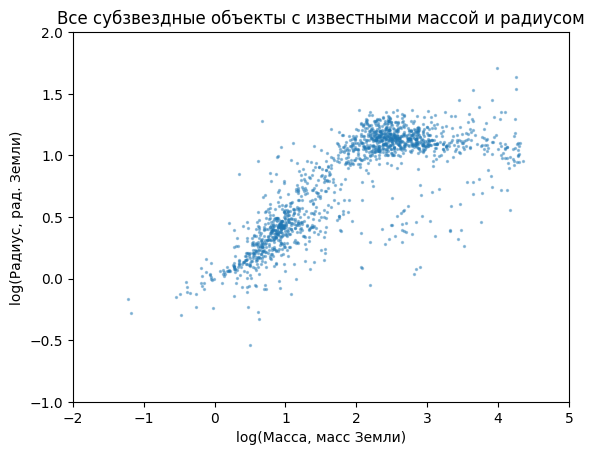

In [25]:
exo_mass_rad = exo_only_comp.query("mass.notna() and radius.notna()")

show_mass_radius_plot(exo_mass_rad, "Все субзвездные объекты с известными массой и радиусом")

Выбор объектов, с точно измеренными массой и радиусом

Выбираются объекты, относительная погрешность которых не превышает MAX_REL_ERR

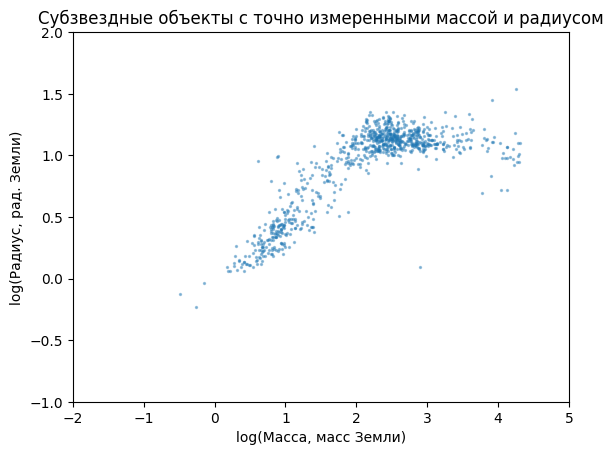

In [26]:
MAX_REL_ERR = 0.2

precise_q = "(mass_error_min + mass_error_max) / 2 < mass * {rel_err} and (radius_error_min + radius_error_max) / 2 < radius * {rel_err}".format(rel_err=MAX_REL_ERR)
exo_precise = exo_mass_rad.query(precise_q)

show_mass_radius_plot(exo_precise, "Субзвездные объекты с точно измеренными массой и радиусом")

Выбор объектов планетарной массы

Объектами планетарной массы будем считать те объекты, масса которых не превышает MAX_PL_MASS_JUP масс ЮПИТЕРА

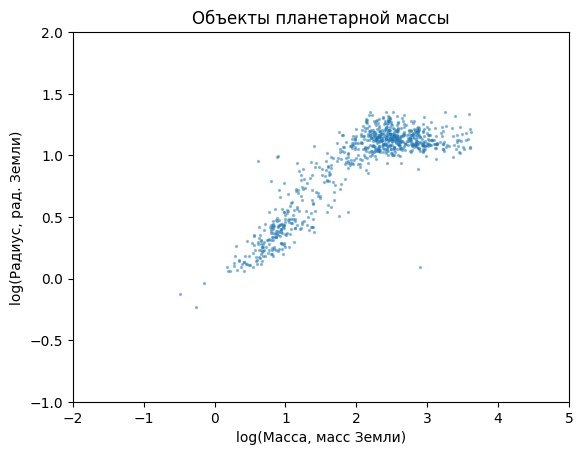

In [27]:
MAX_PL_MASS_JUP = 13

only_planets_q = "mass < {mass}".format(mass=MAX_PL_MASS_JUP)
exo_only_planets = exo_precise.query(only_planets_q)

show_mass_radius_plot(exo_only_planets, "Объекты планетарной массы")

Сохраняем предварительно отфильтрованные данные в файл

In [28]:
exo_only_planets = exo_only_planets.set_index(pd.RangeIndex(start=0, stop=len(exo_only_planets), step=1))
exo_only_planets.to_csv("exo_filtered.csv")

In [29]:
SP_CLASS_TABLE = {
    "B": (10000.0, 30000.0),
    "A": (7400.0, 10000.0),
    "F": (6000.0, 7400.0),
    "G": (5000.0, 6000.0),
    "K": (3800.0, 5000.0),
    "M": (2500.0, 3800.0)
}

<h2>Расчет недостающих данных</h2>

In [30]:
converter = conv.MeasureConverter()

err_gen_by_order = err.ErrorGeneratorByOrder()
err_gen_star_teff = err.ErrorGeneratorStarTeff()

period_err_gen = trans.DFErrorGen(converter, err_gen_by_order, "orbital_period", ms.OrbitalPeriod)
smass_err_gen = trans.DFErrorGen(converter, err_gen_by_order, "star_mass", ms.SemiMajorAxis)
steff_err_gen = trans.DFErrorGen(converter, err_gen_star_teff, "star_teff", ms.StarTeff)
smaxis_err_gen = trans.DFErrorGen(converter, err_gen_by_order, "semi_major_axis", ms.SemiMajorAxis)

calc_df = period_err_gen.gen(exo_only_planets)
calc_df = smass_err_gen.gen(calc_df)
calc_df = steff_err_gen.gen(calc_df)
calc_df = smaxis_err_gen.gen(calc_df)

rou = err.Round()

steff_table = tab.SpClassTeffTable(SP_CLASS_TABLE)

steff_calc_df = trans.DFStarTeffBySpClassCalc(converter, steff_table)

calc_df = steff_calc_df.set_vals(calc_df)

smaxis_calc = calc.SemiMajorAxisCalc()
pteff_mean_calc = calc.PlanetTeffCalc()

sm_axis_calc_df = trans.DFSemiMajorAxisCalc(converter, smaxis_calc, rou)
pteff_mean_calc_df = trans.DFPlanetTeffMeanCalc(converter, pteff_mean_calc, rou)

calc_df = sm_axis_calc_df.calc(calc_df)
calc_df = pteff_mean_calc_df.calc(calc_df)

calc_df.to_csv("exo_with_teff.csv")

In [31]:
BG_COLOR = "0.15"
PLOT_BG_COLOR = "0.18"
T_TITLE_COLOR = "white"
T_COLOR = "0.8"

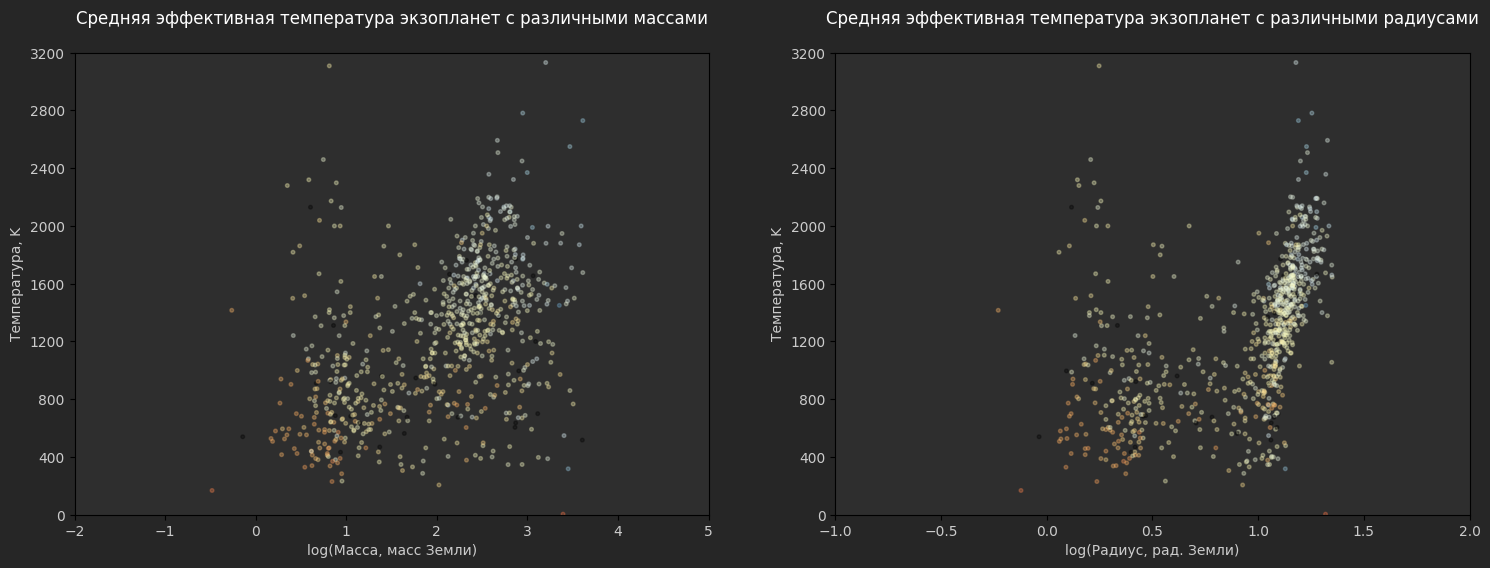

In [32]:
mean_teff = calc_df.get("temp_calculated").tolist()
star_teff = calc_df.get("star_teff").tolist()
mass = get_log_mass(exo_only_planets)
radius = get_log_rad(exo_only_planets)

fig, axes = plot.subplots(facecolor=BG_COLOR, ncols=2)

fig.set_figwidth(18)
fig.set_figheight(6)

colormap = colormaps.get_cmap("RdYlBu")
norm = color.Normalize(0, 11000)

axes[0].scatter(mass, mean_teff, s=7, alpha=0.33, color=colormap(norm(star_teff)))
axes[1].scatter(radius, mean_teff, s=7, alpha=0.33, color=colormap(norm(star_teff)))

for a in axes:
    a.set_facecolor(PLOT_BG_COLOR)

    a.set_ylabel("Температура, K", color=T_COLOR)
    a.set_ylim(0, 3000)
    a.set_yticks(np.arange(0, 3600, 400))

    a.tick_params(labelcolor=T_COLOR)

axes[0].set_title("Cредняя эффективная температура экзопланет с различными массами\n", color=T_TITLE_COLOR)
axes[0].set_xlabel("log(Масса, масс Земли)", color=T_COLOR)
axes[0].set_xlim(-2, 5)

axes[1].set_title("Cредняя эффективная температура экзопланет с различными радиусами\n", color=T_TITLE_COLOR)
axes[1].set_xlabel("log(Радиус, рад. Земли)", color=T_COLOR)
axes[1].set_xlim(-1, 2)

plot.show()